***
# HCI 2022 Final Exam
*Matthew Kenworthy // Leiden Observatory*
***

This is the final exam for the HCI 2022 course.
***

### The exam rules

The exam is FOR YOU ONLY. Do not work with anyone else on this exam.

You may reuse code from your own Notebooks from the HCI course.

Do NOT import any additional Python modules. 

Answer the questions fully in English in a cell after the question. There are **10 points in total** on this exam.

All graphs and plot axes **MUST** be labelled with quantities and units where appropriate. You will lose points if we cannot determine what your plot is showing.

DO NOT discuss the exam with other students from the HCI course. If you have questions about the exam, please send us a message through Brightspace.

***
### Submission

<div class="alert alert-block alert-danger">
<b>DEADLINE FOR SUBMISSION OF THE EXAM IS 23:59 on FRIDAY 20 MAY</b>
</div>

Please replace ``YOUR_NAME`` with your name and upload the Notebook through Brightspace before the deadline.

The notebook **must compile cleanly** (``Cell => All Output=> Clear`` and then ``Cell => Run All`` must produce all your graphs and plots and images without an error) and should contain all subroutines required for data reduction.

<div class="alert alert-block alert-danger">
<b>If the notebook does NOT complile cleanly, you will LOSE MARKS on this final exam.</b>
</div>

***
### Let's find the candidate companion

The data for the exam is of a nearby star with a candidate companion imaged near it. The goal of the exam is to find the candidate companion.

There is a data cube called ``sci.fits`` and an associated file called ``angles.dat`` that contains angles in degrees read out from the telescope derotator.
  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')

from astropy.io import ascii

def wfits(im, fname):
    """wfits - write im to file fname, automatically overwriting any old file"""
    from astropy.io import fits
    hea = fits.PrimaryHDU(im)
    hea.writeto(fname, overwrite=True)
    
    
# read in the data cube
im, he = fits.getdata('sci.fits', header=True)

# read in the rotation angles
t = ascii.read('angles.dat')
rot = t['ang']

### From previous assignmnets

In [2]:
# week 8
def r_theta(im, xc, yc):
    """r_theta - make a radius mask and return the radius rr and the angle phi for point (xc,yc)"""
    ny, nx = im.shape
    yp, xp = np.mgrid[0:ny,0:nx]
    yp = yp - yc
    xp = xp - xc
    rr = np.sqrt(np.power(yp,2.) + np.power(xp,2.))
    phi = np.arctan2(yp, xp)
    return(rr, phi)

from scipy.ndimage import affine_transform
def cen_rot2 (im, rot, dim_out, offset1=(0,0), offset2=(0,0), order=2):
    """cen_rot2 - takes a cube of images im, and a set of rotation angles in rot,
                and translates the middle of the frame with a size dim_out to the middle of
                a new output frame with an additional rotation of rot.
                """
    a = rot * np.pi / 180.
    
    # make a rotation matrix
    transform=np.array([[np.cos(a),-np.sin(a)],[np.sin(a),np.cos(a)]])
    
    # calculate total offset for image output
    # determine centre of input image

    # -0.5 is there for fencepost counting error
    c_in = np.array(offset1) - 0.5
    c_out = 0.5 * np.array(dim_out) - 0.5

    # c_out has to be pre-rotated to make offset correct
    offset = c_in - c_out.dot(transform) - np.array(offset2).dot(transform)
    
    # perform the transformation
    dst=affine_transform( \
        im,transform.T, order=order,offset=offset, \
        output_shape=dim_out, cval=0.0)
    return(dst)

def derot_cube(imin, rotangle, out_dims, star_cen):
    """derot_cube - takes a cube of images im, and a set of rotation angles in rot,
                and translates the middle of the frame with a size dim_out to the middle of
                a new output frame with an additional rotation of rot degrees.
                """
    # get shape of input image
    nim, nx, ny = imin.shape
    
    # make a zero value numpy array for the output
    im_out = np.zeros((nim, out_dims[0], out_dims[1]))
    
    # for every frame in imin perform the derotation of rotangle
    for j, frame in enumerate(np.split(imin, nim, axis=0)):
        frame_sq = np.squeeze(frame)
        frame_rot = cen_rot2(frame_sq, rotangle[j], out_dims, offset1=star_cen)
        im_out[j,:,:] = frame_rot
        
    return(im_out)

### Prelim data analysis

#### Angles & Images

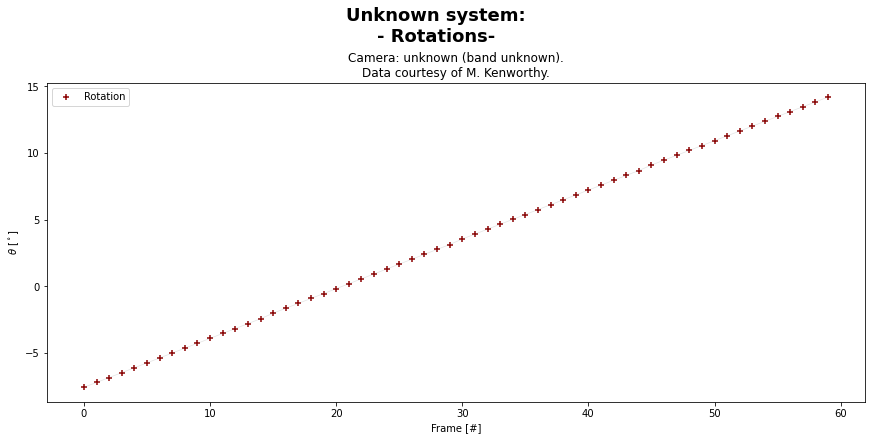

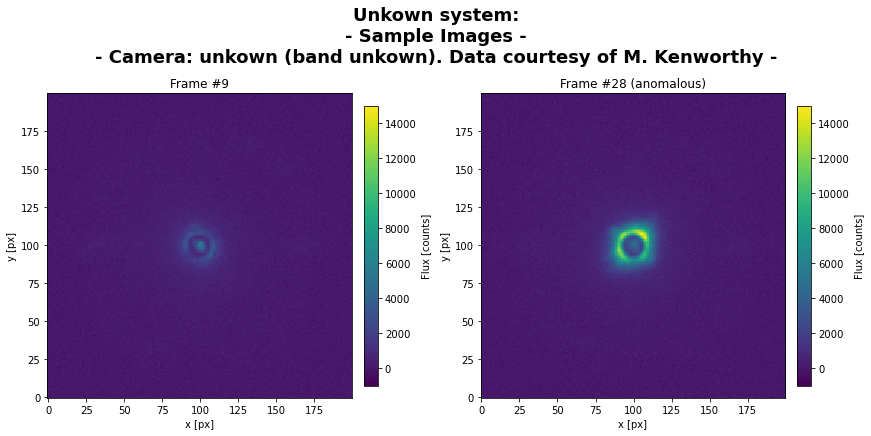

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 6))

x = np.arange(len(rot))

ax.plot(x, rot, c="gray", ls="solid", alpha=0.2, lw=0.75)
ax.scatter(x, rot, c="darkred", marker="+", label="Rotation")

ax.set_xlabel(r'Frame [#]')
ax.set_ylabel(r'$\theta$ [$^\circ$]')
ax.legend()
ax.set_title('Camera: unknown (band unknown).\nData courtesy of M. Kenworthy.') 
fig.suptitle(r'Unknown system:'f'\n- Rotations-', fontsize=18, weight="bold")
plt.show()

# ======================================

sample_img1, sample_img2 = np.copy(im[9]), np.copy(im[28])

fig, axes = plt.subplots(nrows=1, ncols=2,
                         constrained_layout=True,
                         figsize=(12, 6))

ax0, ax1 = axes

this_im = ax0.imshow(sample_img1,
                     vmax=15000, vmin=-1000)
plt.colorbar(this_im, ax=ax0, label=r"Flux [counts]", fraction=0.046, pad=0.04)
ax0.set_xlabel('x [px]')
ax0.set_ylabel('y [px]')
ax0.set_title('Frame #9')


this_im = ax1.imshow(sample_img2,
                     vmax=15000, vmin=-1000)
plt.colorbar(this_im, ax=ax1, label=r"Flux [counts]", fraction=0.046, pad=0.04)
ax1.set_xlabel('x [px]')
ax1.set_ylabel('y [px]')
ax1.set_title('Frame #28 (anomalous)')

fig.suptitle(r'Unkown system:'
             f'\n- Sample Images -'
             f'\n- Camera: unkown (band unkown). Data courtesy of M. Kenworthy -',
             fontsize=18, weight="bold")
plt.show()


#### Data shapes

In [4]:
print(f"Number of rotatons: {rot.shape}")
print(f"Data cube shape: {im.shape}")
print()

Number of rotatons: (60,)
Data cube shape: (60, 200, 200)




---
<span style="  font-size:2em; color: SteelBlue;">Question 1</span> <span style="  font-size:1em; color: SteelBlue;">
(1 point): </span><br>
**What type of diversity is being used in this data?**

---

#### Q1 answer here
The images vary in the rotation they were taken at, so that the diversity in the data is rotation of the observing instrument.

The camera uses a focal plane coronagraph, which makes the data unreliable in the middle of the image. To be safe, you must ignore the central PSF core and the bright ring of light surrounding the core (this is star light scattered from the inner edge of the coronagraph focal plane mask).

---
<span style="  font-size:2em; color: SteelBlue;">Question 2</span> <span style="  font-size:1em; color: SteelBlue;">
(1 point): </span>

1. **Choose one of the images from the data cube, and plot out the values of one row that passes through the centre of the PSF. Label the axes as <code>pixel position </code> and <code>flux [counts]</code>**
2. **By visual inspection, look at one of the images from the image cube and estimate the radius in pixels which should be ignored (because of the coronagraph used and saturation) in the data processing.**
3. **Choose one of the images in the data cube, cut out a 39 by 39 pixel box centered on the star, and draw a red circle centered on the star**


<div class="alert alert-block alert-info">
<b>NOTE:</b> The data within this circle should be ignored in all subsequent data reduction </div>

---

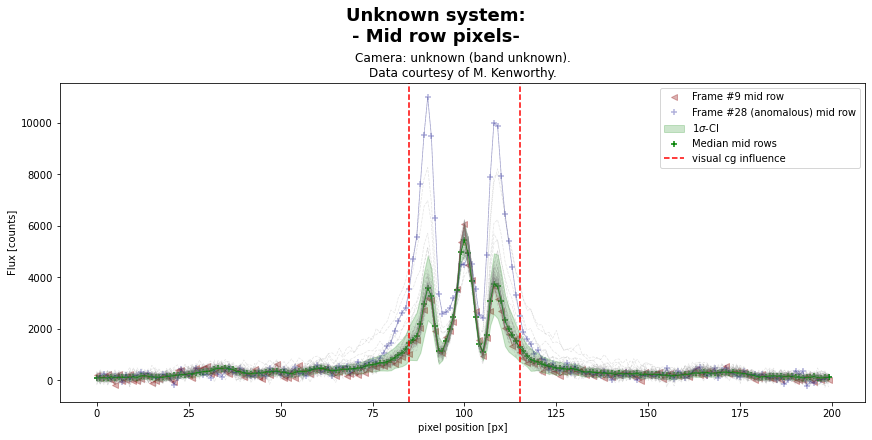

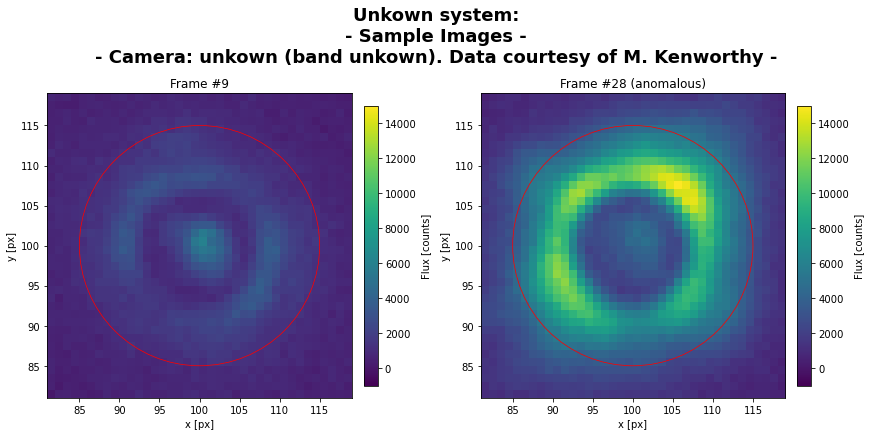

In [5]:
# Q2 answer here

rad_bad = 15

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 6))

mid_row1, mid_row2 = sample_img1[100], sample_img2[100]
_median_midrow = im[:, 100:102]
median_midrow = np.median(_median_midrow, axis=(0, 1))
std_midrow = np.std(_median_midrow, axis=(0, 1))

x = np.arange(len(mid_row1))

for img in im:
    ax.plot(x, img[100], c="gray", ls="dashed", alpha=0.2, lw=0.75)

ax.plot(x, mid_row1, c="darkred", ls="solid", alpha=0.3, lw=0.75)
ax.scatter(x, mid_row1, c="darkred", marker="<", alpha=0.3, label="Frame #9 mid row")

ax.plot(x, mid_row2, c="darkblue", ls="solid", alpha=0.3, lw=0.75)
ax.scatter(x, mid_row2, c="darkblue", marker="+", alpha=0.3, label="Frame #28 (anomalous) mid row")

ax.fill_between(x,
               median_midrow + std_midrow,
               median_midrow - std_midrow,
               color="green", alpha=0.2,
               label=r"$1\sigma$-CI")

ax.plot(x, median_midrow, c="green", ls="solid", alpha=0.8, lw=0.75)
ax.scatter(x, median_midrow, c="green", marker="+", label="Median mid rows")

ax.axvline(100 - rad_bad, c="red", ls="dashed")
ax.axvline(100 + rad_bad, c="red", ls="dashed", label="visual cg influence")

ax.set_xlabel(r'pixel position [px]')
ax.set_ylabel(r'Flux [counts]')
ax.legend()
ax.set_title('Camera: unknown (band unknown).\nData courtesy of M. Kenworthy.') 
fig.suptitle(r'Unknown system:'f'\n- Mid row pixels-', fontsize=18, weight="bold")
plt.show()

# ========================

fig, axes = plt.subplots(nrows=1, ncols=2,
                         constrained_layout=True,
                         figsize=(12, 6))

ax0, ax1 = axes

this_im = ax0.imshow(sample_img1[100-39//2: 100+39//2, 100-39//2: 100+39//2],
                     vmax=15000, vmin=-1000,
                          extent=[100-39//2, 100+39//2, 100-39//2, 100+39//2])
circ0 = mpl.patches.Circle((100, 100), rad_bad,
             facecolor=None, edgecolor="r", antialiased=True, lw=0.75, fill=False)
ax0.add_patch(circ0)

plt.colorbar(this_im, ax=ax0, label=r"Flux [counts]", fraction=0.046, pad=0.04)
ax0.set_xlabel('x [px]')
ax0.set_ylabel('y [px]')
ax0.set_title('Frame #9')


this_im = ax1.imshow(sample_img2[100-39//2: 100+39//2, 100-39//2: 100+39//2],
                     vmax=15000, vmin=-1000,
                    extent=[100-39//2, 100+39//2, 100-39//2, 100+39//2])
circ1 = mpl.patches.Circle((100, 100), rad_bad,
             facecolor=None, edgecolor="r", antialiased=True, lw=0.75, fill=False)
ax1.add_patch(circ1)

plt.colorbar(this_im, ax=ax1, label=r"Flux [counts]", fraction=0.046, pad=0.04)
ax1.set_xlabel('x [px]')
ax1.set_ylabel('y [px]')
ax1.set_title('Frame #28 (anomalous)')

fig.suptitle(r'Unkown system:'
             f'\n- Sample Images -'
             f'\n- Camera: unkown (band unkown). Data courtesy of M. Kenworthy -',
             fontsize=18, weight="bold")
plt.show()





---
<span style="  font-size:2em; color: SteelBlue;">Question 3</span> <span style="  font-size:1em; color: SteelBlue;">
(4 points): </span>

1. **Reduce the data cube using one of the algorithms covered in the course.** 
2. **Produce a final reduced image with the central star in the centre of the image.** 
3. **Show the location of the point source closest to the star using a red circle in your final reduced image.**

<div class="alert alert-block alert-info">
<b>Hint:</b> You should use a mask to ignore data close to the star and data far away from the star. The inner radius of your mask should be the radius determined in Q2. This allows us to exclude the saturated data. You can set the outer radius of the mask to be 96 pixels.</div>

---


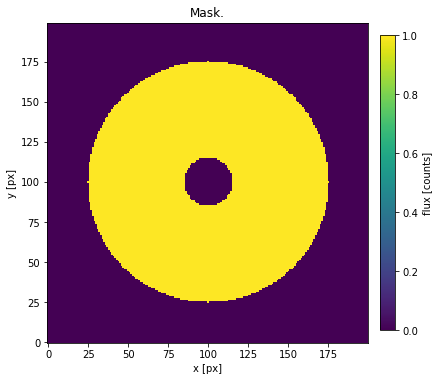

In [6]:
# Q3 answer here
rad_bad_outer = 75
rr, __ = r_theta(im[0], 100, 100)
mask = (rr >= rad_bad) * (rr <= rad_bad_outer)

fig, ax = plt.subplots(nrows=1, ncols=1,
                     constrained_layout=True,
                     figsize=(6, 6)) # figsize=(width, height)

this_im = ax.imshow(mask)

plt.colorbar(this_im, ax=ax, label=r"flux [counts]", fraction=0.046, pad=0.04)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
ax.set_title('Mask.') 

plt.show()

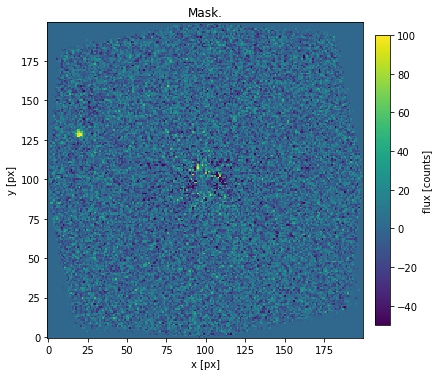

In [74]:
im_median = np.median(im, axis=0)
im_medsub = im - im_median

im_ADI = np.array([cen_rot2(img, r, (200, 200), offset1=(100, 100)) 
                   for img, r in zip(im_medsub,
                                     -rot)])




fig, ax = plt.subplots(nrows=1, ncols=1,
                     constrained_layout=True,
                     figsize=(6, 6)) # figsize=(width, height)

this_im = ax.imshow(np.median(im_ADI, axis=0), vmin=-50., vmax=100)

plt.colorbar(this_im, ax=ax, label=r"flux [counts]", fraction=0.046, pad=0.04)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
ax.set_title('ADI.') 

plt.show()

(60, 16968)
Shape of U:       (60, 60)
Shape of s:       (60,)
Shape of V:       (60, 16968)
(60,) (60,)


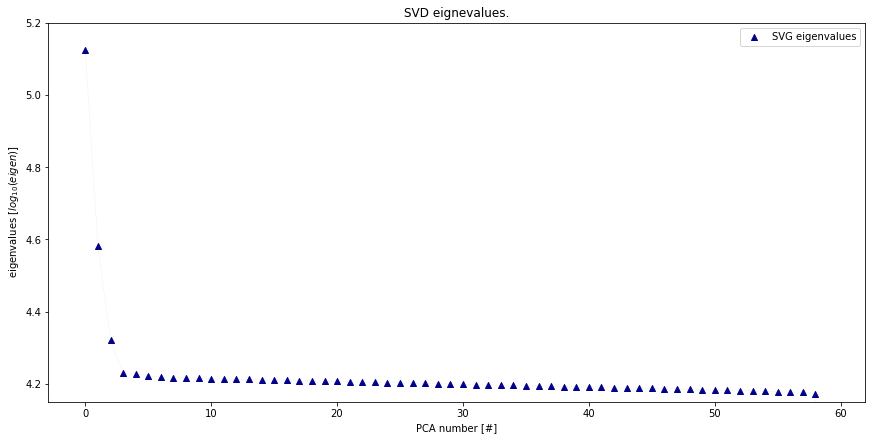

Shape of Uk:       (60, 4)
Shape of sk:       (4,)
Shape of Vk:       (4, 16968)


ValueError: shapes (4,16968) and (200,200,60) not aligned: 16968 (dim 1) != 200 (dim 1)

In [79]:
im_medsub_mean = np.mean(im_medsub, axis=0)
_im = im_medsub - im_medsub_mean

masked_im = _im[:, mask]



print(masked_im.shape)

U, s, V = np.linalg.svd(masked_im, full_matrices=False, compute_uv=True)
print("Shape of U:       {}".format(U.shape))
print("Shape of s:       {}".format(s.shape))
print("Shape of V:       {}".format(V.shape))

S = np.diag(s)



fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 6))

x = np.arange(len(s))

print(s.shape, x.shape)

ax.plot(x, np.log10(s), c="gray", ls="dotted", alpha=0.2, lw=0.75)
ax.scatter(x, np.log10(s), c="darkblue", marker="^", label="SVG eigenvalues")

ax.set_ylim(4.15, 5.2)

ax.set_xlabel(r'PCA number [#]')
ax.set_ylabel(r' eigenvalues [$log_{10}(eigen)$]')

ax.legend()
ax.set_title('SVD eignevalues.') 
plt.show()


k=4
Uk = U[:,:k]
sk = s[:k]
Vk = V[:k,:]

print("Shape of Uk:       {}".format(Uk.shape))
print("Shape of sk:       {}".format(sk.shape))
print("Shape of Vk:       {}".format(Vk.shape))


transformed = np.dot(Vk, _im.T)

reconstructed = np.dot(transformed.T, Vk)

residuals = _im - reconstructed

resid = np.zeros_like(im)
resid = np.swapaxes(resid,0,-1)

resid[mask] = residuals


im_resid = np.swapaxes(resid, 0, 2)

print(im_resid.shape)

resid_derot = np.array([cen_rot2(im_resid, r, (200, 200), offset1=(100, 100)) 
                   for img, r in zip(im_resid,
                                     -rot)])


PCAmed = np.median(resid_derot, axis = 0)

fig, ax = plt.subplots(nrows=1, ncols=1,
                     constrained_layout=True,
                     figsize=(12, 12)) # figsize=(width, height)

this_im = ax.imshow(PCAmed,
                    vmax=100., vmin=-100.)

plt.colorbar(this_im, ax=ax, label=r"flux [counts]", fraction=0.046, pad=0.04)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')

ax.set_title('Camera: NIRC2 of Keck II (L prime).\nData courtesy of B. Macintosh, T. Barman & R. Galicher.') 
fig.suptitle('HR 8799 - U159N2:\n- PCA (median) -', fontsize=18, weight="bold")
plt.show()

---
<span style="  font-size:2em; color: SteelBlue;">Question 4</span> <span style="  font-size:1em; color: SteelBlue;">
(1 point): </span>

1. **Locate the closest point source to the star. Determine the angular separation in pixels between the planet and star to an accuracy of 1 pixel.** 
2. **Print out this distance using a formatted print statement.** 
3. **Display an image of the planet zoomed in to a size of a square box with 20 pixels to demonstrate you have identified the planet.**

---

In [7]:
# Q4 answer here



---
<span style="  font-size:2em; color: SteelBlue;">Question 5</span> <span style="  font-size:1em; color: SteelBlue;">
(1 point): </span>

1. **Assuming a pixel scale of $12.00\pm 0.05$ milliarcsec per pixel, determine the angular separation of the planet in arcseconds, and the position angle of the planet in degrees, both with estimated errors on these quantities.** 


<div class="alert alert-block alert-info">
<b>Remember:</b> you have an error of 0.5 pixel for your estimated position of the planet rounded to the nearest pixel. </div>


2. **Print out this distance with its error using a formatted print statement.** 

---


In [8]:
# Q5 answer here



---
<span style="  font-size:2em; color: SteelBlue;">Question 6</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

1. **Measure the flux of the planet using an aperture that is 90 milliarcseconds in diameter and centered on the planet. Print the answer using a formatted print statement. Once more, do not forget about the error.** 


<div class="alert alert-block alert-info">
<b>Remember:</b> to estimate the sky background using a similar sized aperture at the same angular distance from the star but close to the location of the planet. </div>


2. **Print the r.m.s. per pixel in the sky background aperture, and print the summed planet flux corrected for the sky background level .** 

---


In [9]:
# Q6 answer here



***

<span style="  font-size:2em; color: SteelBlue;">Last, but important question</span> 

---

### How long did this Exam take?
Please enter the number of hours you spent on this exam below:

In [10]:
# Number of hours taken for this practicum:
